In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.tree import export_graphviz
from pydotplus import graph_from_dot_data
from IPython.display import Image
import warnings
warnings.filterwarnings('ignore')
sns.set_style('darkgrid')
%matplotlib inline

In [3]:
df = pd.read_csv('cleaned_churn_data.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 29 columns):
Unnamed: 0                     3333 non-null int64
account length                 3333 non-null int64
area code                      3333 non-null int64
international plan             3333 non-null int64
voice mail plan                3333 non-null int64
number vmail messages          3333 non-null int64
total day minutes              3333 non-null float64
total day calls                3333 non-null int64
total day charge               3333 non-null float64
total eve minutes              3333 non-null float64
total eve calls                3333 non-null int64
total eve charge               3333 non-null float64
total night minutes            3333 non-null float64
total night calls              3333 non-null int64
total night charge             3333 non-null float64
total intl minutes             3333 non-null float64
total intl calls               3333 non-null int64
total intl c

In [6]:
X = df.drop(labels=['number vmail messages', 'churn'], axis=1)
y = df['churn'].astype(int)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [10]:
y_train.value_counts()

0    2130
1     369
Name: churn, dtype: int64

In [9]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_sample(X_train, y_train)

In [11]:
y_train_resampled.value_counts()

1    2130
0    2130
Name: churn, dtype: int64

In [13]:
logistic_pipeline = Pipeline([('ss', StandardScaler()),
                              ('LR', LogisticRegression(solver='liblinear', fit_intercept=False, random_state=42))])

In [14]:
logistic_grid = [{'LR__C': [1, 50, 2000, 1e15],
                  'LR__penalty': ['l1', 'l2']}]

logistic_gridsearch = GridSearchCV(estimator=logistic_pipeline,
                                   param_grid=logistic_grid,
                                   scoring='accuracy',
                                   cv=5)

In [15]:
logistic_gridsearch.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('LR',
                                        LogisticRegression(fit_intercept=False,
                                                           random_state=42,
                                                           solver='liblinear'))]),
             param_grid=[{'LR__C': [1, 50, 2000, 1000000000000000.0],
                          'LR__penalty': ['l1', 'l2']}],
             scoring='accuracy')

In [16]:
logistic_gridsearch.score(X_test, y_test)

0.8309352517985612

In [17]:
y_hat_train = logistic_gridsearch.predict(X_train_resampled)
y_hat_test = logistic_gridsearch.predict(X_test)

print('Training Precision: ', precision_score(y_train_resampled, y_hat_train))
print('Testing Precision: ', precision_score(y_test, y_hat_test))
print('')

print('Training Recall: ', recall_score(y_train_resampled, y_hat_train))
print('Testing Recall: ', recall_score(y_test, y_hat_test))
print('')

print('Training Accuracy: ', accuracy_score(y_train_resampled, y_hat_train))
print('Testing Accuracy: ', accuracy_score(y_test, y_hat_test))
print('')

print('Training F1-Score: ', f1_score(y_train_resampled, y_hat_train))
print('Testing F1-Score: ', f1_score(y_test, y_hat_test))

Training Precision:  0.8571428571428571
Testing Precision:  0.41509433962264153

Training Recall:  0.7183098591549296
Testing Recall:  0.5789473684210527

Training Accuracy:  0.7992957746478874
Testing Accuracy:  0.8309352517985612

Training F1-Score:  0.7816091954022989
Testing F1-Score:  0.4835164835164836


In [18]:
logistic_cnf_matrix = confusion_matrix(y_test, y_hat_test)

print(logistic_cnf_matrix)

[[627  93]
 [ 48  66]]


In [19]:
rf_pipeline = Pipeline([('ss', StandardScaler()),
                        ('RF', RandomForestClassifier(random_state = 42))])

In [21]:
rf_model = rf_pipeline.fit(X_train, y_train)

In [22]:
rf_model.score(X_train, y_train)

1.0

In [23]:
rf_model.score(X_test, y_test)

0.9508393285371702

In [24]:
rf_preds = rf_model.predict(X_test)

In [27]:
from sklearn.metrics import classification_report

target_names = ['not_churn', 'churn']
print(classification_report(y_test, rf_preds, target_names = target_names))

              precision    recall  f1-score   support

   not_churn       0.95      0.99      0.97       720
       churn       0.92      0.70      0.80       114

    accuracy                           0.95       834
   macro avg       0.94      0.85      0.88       834
weighted avg       0.95      0.95      0.95       834



In [28]:
rf_model_smote = rf_pipeline.fit(X_train_resampled, y_train_resampled)
rf_smote_preds = rf_model_smote.predict(X_test)
print(classification_report(y_test, rf_smote_preds, target_names = target_names))

              precision    recall  f1-score   support

   not_churn       0.94      0.95      0.95       720
       churn       0.69      0.63      0.66       114

    accuracy                           0.91       834
   macro avg       0.81      0.79      0.80       834
weighted avg       0.91      0.91      0.91       834



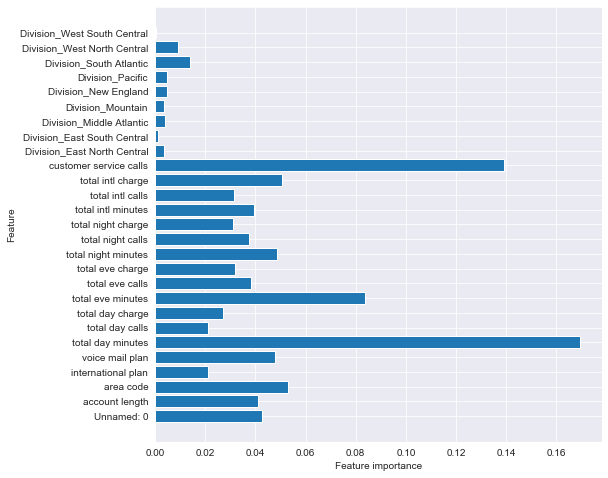

In [33]:
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

plot_feature_importances(rf_model_smote[1][1])

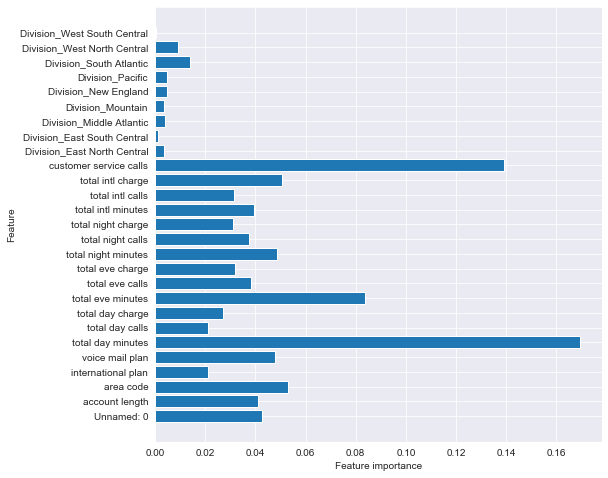

In [34]:
plot_feature_importances(rf_model[1][1])

In [30]:
def model_performance(y_test, y_preds):
    print("Code for confusion matrix")
    print(classification_report(y_test, rf_smote_preds, target_names = target_names))

In [31]:
def model_predictions(model):
    pass

In [37]:
rf_model[1].estimators_[0]

DecisionTreeClassifier(max_features='auto', random_state=1608637542)

In [38]:
# Create DOT data
dot_data = export_graphviz(rf_model[1].estimators_[0], out_file=None, 
                           feature_names=X_train.columns,  
                           class_names=np.unique(y_train).astype('str'), 
                           filled=True, rounded=True, special_characters=True)

# Draw graph
graph = graph_from_dot_data(dot_data)  

# Show graph
Image(graph.create_png())

In [39]:
rf_model[1][1].feature_importances_

array([0.04255492, 0.04087876, 0.05311246, 0.02124531, 0.04789153,
       0.16958819, 0.02125221, 0.02716412, 0.0838088 , 0.03817163,
       0.03196606, 0.04870264, 0.03742622, 0.03094703, 0.03947175,
       0.03138067, 0.05058897, 0.13896519, 0.00356978, 0.00107423,
       0.00384759, 0.00331984, 0.00476243, 0.00461991, 0.01406747,
       0.0091874 , 0.0004349 ])

In [53]:
rf_grid = [{'RF__max_depth': [1,None]},
          {'RF__min_samples_split': [4,6,8]}]

In [59]:
grid = [{'RF__max_depth': [4, 5, 6], 
         'RF__min_samples_split': [2, 5, 10], 
         'RF__min_samples_leaf': [1, 3, 5]}]

In [60]:
rf_gridsearch = GridSearchCV(estimator=rf_pipeline,
                                   param_grid=grid,
                                   scoring='accuracy',
                                   cv=5)

In [61]:
rf_gridsearch.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('RF',
                                        RandomForestClassifier(random_state=42))]),
             param_grid=[{'RF__max_depth': [4, 5, 6],
                          'RF__min_samples_leaf': [1, 3, 5],
                          'RF__min_samples_split': [2, 5, 10]}],
             scoring='accuracy')

In [62]:
rf_gridsearch.best_params_

{'RF__max_depth': 6, 'RF__min_samples_leaf': 1, 'RF__min_samples_split': 5}

In [63]:
rf_gridsearch.cv_results_

{'mean_fit_time': array([0.31279373, 0.29788604, 0.27361903, 0.24888301, 0.23399   ,
        0.27079759, 0.22075028, 0.21800051, 0.20323634, 0.23726325,
        0.22567458, 0.24377894, 0.25689483, 0.29005799, 0.29755006,
        0.32476945, 0.32391129, 0.33768754, 0.39959655, 0.40048022,
        0.39481874, 0.33900504, 0.33703556, 0.32323408, 0.29245815,
        0.26623211, 0.28802261]),
 'std_fit_time': array([0.04070001, 0.01398852, 0.01306651, 0.0136851 , 0.00717941,
        0.0123112 , 0.00739707, 0.01240536, 0.00876448, 0.01008032,
        0.00880861, 0.00417051, 0.00317956, 0.00374291, 0.01447092,
        0.01189696, 0.02279223, 0.02473433, 0.01913817, 0.01626771,
        0.01578484, 0.01530203, 0.01817305, 0.02269907, 0.01628999,
        0.01909034, 0.00898911]),
 'mean_score_time': array([0.02205453, 0.02301202, 0.01992674, 0.01767936, 0.01779952,
        0.01995282, 0.01623936, 0.01604285, 0.01455097, 0.01622334,
        0.01508598, 0.01703372, 0.01897969, 0.01992793, 0.021830